# Stock Forecast

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer

In [2]:
# Define the ticker symbol and date range
ticker = "AAPL"
start_date = "2023-01-01"
end_date = "2024-01-01"

# Download stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Print the first few rows of the dataframe
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  124.048050   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.327515   
2023-01-05  127.129997  127.769997  124.760002  125.019997  123.998459   
2023-01-06  126.010002  130.289993  124.889999  129.619995  128.560867   
2023-01-09  130.470001  133.410004  129.889999  130.149994  129.086548   

               Volume  
Date                   
2023-01-03  112117500  
2023-01-04   89113600  
2023-01-05   80962700  
2023-01-06   87754700  
2023-01-09   70790800  


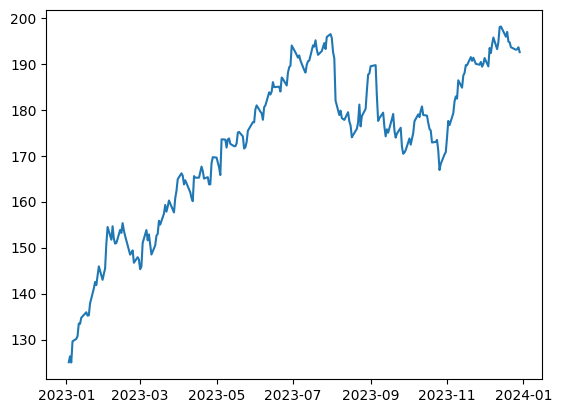

In [3]:
plt.plot(stock_data['Close']);

In [4]:
# Reset index to get date as a column
stock_data = stock_data.reset_index()

# Use only Date and Close columns
data = stock_data[['Date', 'Close']].copy()

# Convert date to numerical format (days since start date)
data.loc[:, 'Date'] = (data['Date'] - data['Date'].min()).dt.days

# Normalize the data
data.loc[:, 'Close'] = (data['Close'] - data['Close'].mean()) / data['Close'].std()

# Adjust the sample size to be smaller than the number of available data points
available_data_points = len(data)
sample_size = min(600, available_data_points)  # Adjust sample size to be smaller than available data

# Reduce the dataset size by taking a random sample
data_sample = data.sample(n=sample_size, random_state=1).sort_values(by='Date')

# Split the data into training and test sets
train_size = int(len(data_sample) * 0.9)
data_train = data_sample.iloc[:train_size]
data_test = data_sample.iloc[train_size:]

# Convert to numpy arrays for use in GP regression
X_train = data_train['Date'].values[:, None]
y_train = data_train['Close'].values

X_test = data_test['Date'].values[:, None]
y_test = data_test['Close'].values

### Split Test

In [5]:
# Split the data into training and test sets
train_size = int(len(data_sample) * 0.9)
data_train = data_sample.iloc[:train_size]
data_test = data_sample.iloc[train_size:]

# Convert to numpy arrays for use in GP regression
X_train = data_train['Date'].values[:, None]
y_train = data_train['Close'].values

X_test = data_test['Date'].values[:, None]
y_test = data_test['Close'].values

In [6]:
# Function to optimize
def gp_objective(params):
    alpha_rq, lengthscale_rq, lengthscale_per, period, sigma_noise = params
    
    with pm.Model() as model:
        # Rational Quadratic Kernel
        cov_rq = pm.gp.cov.RatQuad(1, alpha=alpha_rq, ls=lengthscale_rq)
        
        # Linear Kernel
        c = pm.Normal("c", mu=0, sigma=1)
        cov_linear = pm.gp.cov.Linear(1, c=c)
        
        # Periodic Kernel
        cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=lengthscale_per)
        
        # Combined Kernel
        cov_combined = cov_rq + cov_linear + cov_periodic + pm.gp.cov.WhiteNoise(sigma_noise)
        
        # Define the GP
        gp = pm.gp.Marginal(cov_func=cov_combined)
        
        # Place a GP prior over the function f
        sigma = pm.HalfNormal("sigma", sigma=1)
        y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)
        
        # Inference
        trace = pm.sample(500, chains=2, tune=1000, target_accept=0.9, return_inferencedata=False, progressbar=False)
        
        # Make predictions for the test dataset
        mu_test, var_test = gp.predict(X_test, point=trace[-1], diag=True)
        
        # Calculate the mean squared error for the test set
        mse = np.mean((mu_test - y_test)**2)
    
    return mse

# Define the parameter space
space = [
    Real(0.1, 10.0, name='alpha_rq'),
    Real(0.1, 10.0, name='lengthscale_rq'),
    Real(0.1, 10.0, name='lengthscale_per'),
    Real(0.1, 10.0, name='period'),
    Real(1e-5, 1e-1, name='sigma_noise')
]

# Run Bayesian optimization
result = gp_minimize(gp_objective, space, n_calls=20, random_state=0)

from IPython.display import clear_output
clear_output()

# Get the optimal parameters
optimal_params = result.x
print(f'Optimal Parameters: {optimal_params}')

Optimal Parameters: [7.826434906723199, 7.166170331985338, 9.008415451058896, 0.4094380895748123, 0.011264124419850304]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, c]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 113 seconds.
/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_35109/1325639366.py:29: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/guneraygin/stock_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


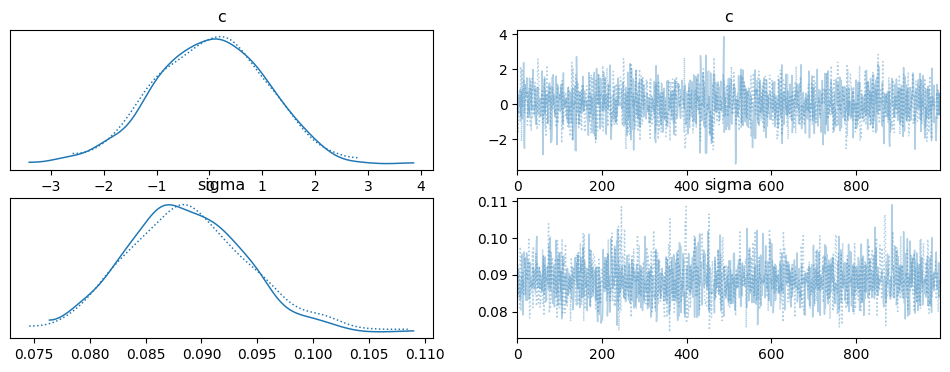

In [10]:
# Use the optimal parameters to train the final model
with pm.Model() as model:
    alpha_rq, lengthscale_rq, lengthscale_per, period, sigma_noise = optimal_params
    
    # RBF Kernel
    cov_rq = pm.gp.cov.RatQuad(1, alpha=alpha_rq, ls=lengthscale_rq)
    
    # Linear Kernel
    c = pm.Normal("c", mu=0, sigma=1)
    cov_linear = pm.gp.cov.Linear(1, c=c)
    
    # Periodic Kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=lengthscale_per)
    
    # Combined Kernel (multiplicative)
    cov_combined = cov_rq + cov_linear + cov_periodic + pm.gp.cov.WhiteNoise(sigma_noise)
    
    # Define the GP
    gp = pm.gp.Marginal(cov_func=cov_combined)
    
    # Place a GP prior over the function f
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)
    
    # Inference
    trace = pm.sample(1000, chains=2, tune=2000, target_accept=0.9, return_inferencedata=False)

# Plot the trace of the parameters
pm.traceplot(trace)
plt.show()

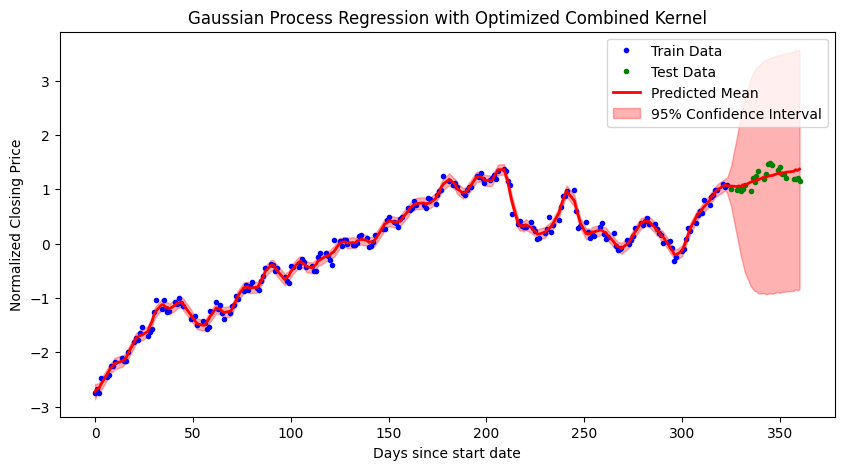

In [11]:
# Make predictions for the entire dataset
X_all = data_sample['Date'].values[:, None]

with model:
    mu_all, var_all = gp.predict(X_all, point=trace[-1], diag=True)

# Make predictions for the test dataset separately for MSE calculation
with model:
    mu_test, var_test = gp.predict(X_test, point=trace[-1], diag=True)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(X_train, y_train, 'b.', label='Train Data')
plt.plot(X_test, y_test, 'g.', label='Test Data')
plt.plot(X_all, mu_all, 'r', lw=2, label='Predicted Mean')
plt.fill_between(X_all.flatten(), mu_all - 1.96 * np.sqrt(var_all), mu_all + 1.96 * np.sqrt(var_all), color='r', alpha=0.3, label='95% Confidence Interval')
plt.title("Gaussian Process Regression with Optimized Combined Kernel")
plt.xlabel("Days since start date")
plt.ylabel("Normalized Closing Price")
plt.legend()
plt.show()

In [12]:
# Calculate and print the mean squared error for the test set
mse = np.mean((mu_test - y_test)**2)
print(f'Mean Squared Error for Test Data: {mse}')

Mean Squared Error for Test Data: 0.014781538164082744
